# 태양열 발전량 데이터 처리 및 모델 적합
---

- 데이터 처리 및 스케일링
- 모델적합

In [178]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time

---

## data 처리

In [5]:
df= pd.read_csv("C:\\Users\\default.DESKTOP-2ISHQBS\\lab\\task1_lee\\data\\solor_wind.csv", encoding='cp949')
df.head()

,거래일자,거래시간,지역명,태양광발전량(Mwh),풍력발전량(Mwh)
0,2023-09-01,1,경기도,0.029757,0.0
1,2023-09-01,2,경기도,0.000000,0.0
2,2023-09-01,3,경기도,0.000000,0.0
3,2023-09-01,4,경기도,0.000000,0.0
4,2023-09-01,5,경기도,0.000000,0.0


In [10]:
land = [i for i in set(df['지역명'])]
land_df= [df[df['지역명'] == land[i]] for i in range(len(land))]

In [12]:
class sample:
    #####################################################################################
    ### 데이터프레임, 날짜 입력
    ### 
    def __init__(self,df,str):
        self.df = df
        self.date= df[str]
        self.date=pd.to_datetime(self.date)
    def monthly(self):    
    #####################################################################################
    ### 시간별 데이터 -> 월별 데이터로
    ### 인덱스 : 년/월, 변수 : y        
        self.train = pd.DataFrame({'date':self.date,'y':self.df.iloc[:,1:].sum(axis=1).values})
        self.train = self.train.groupby(self.train['date'].dt.to_period('M')).sum(numeric_only=True)
        #self.index= self.df.index
        #self.sample = pd.DataFrame(self.df.sum(axis=1))
        #self.sample.columns = ['y']
        return self.train
    def daliy(self):    
    #####################################################################################
    ### 시간별 데이터 -> 일별 데이터로
    ### 인덱스 : 년/월, 변수 : y        
        self.train = pd.DataFrame({'date':self.date,'y':self.df.iloc[:,1:].sum(axis=1).values})
        self.train = self.train.groupby(self.train['date'].dt.to_period('d')).sum(numeric_only=True)
        return self.train

In [53]:
class WINdow:
# data window
# y_label, feature
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
        window_df = self.df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df 

In [132]:
H = 7

test_data = pd.concat([dct[land[i]].daliy().iloc[-28:,:].T for i in range(len(land))])

In [134]:
# 지역별 일별 측정 데이터 분리
dct = {land[i]:sample(land_df[i].iloc[:,[0,3]],'거래일자') for i in range(len(land))}
# 모든 지역의 일별 태양열 발전량 window화 및 통합
targetdata = pd.concat([WINdow(dct[land[i]].daliy().iloc[:-H,:],28).window() for i in range(len(land))], axis=0)


from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
minmax.fit(targetdata.iloc[:,:-1])
scale_train= minmax.transform(targetdata.iloc[:,:-1])
scale_test = minmax.transform(test_data)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12012\204478533.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12012\204478533.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12012\204478533.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [150]:
train_X=scale_train[:,:21]
train_y=scale_train[:,-7:]
test_X=scale_test[:,:21]
test_y=scale_test[:,-7:]

train_X.shape,train_y.shape, test_X.shape, test_y.shape

((952, 21), (952, 7), (17, 21), (17, 7))

---
# nbeats fitting 

In [249]:
input_dim, output_dim =  1, 1
backcast=train_X.shape[1] # 21
forecast = train_y.shape[1] #7

K.clear_session()
model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(2,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer )
#model.summary()

In [250]:

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
nbeat_time1 = time.time()
history = model.fit(train_X,train_y, validation_data = [test_X,test_y],
                    epochs=20, batch_size=16, verbose=0,
                    callbacks=[early_stop])
nbeat_time2 = time.time()

In [251]:
total_training_time0 =nbeat_time2- nbeat_time1

print(f"총 학습에 걸린 시간: {total_training_time0} 초")

총 학습에 걸린 시간: 5.73356294631958 초


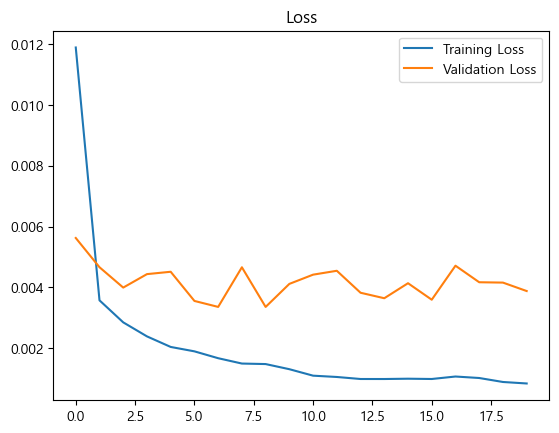

In [252]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

---
## 비교군1 lstm

In [170]:
from keras.layers import *
from tensorflow.keras.models import Sequential

In [231]:
K.clear_session()
modelnon0 = Sequential() # Sequeatial Model
modelnon0.add(LSTM(128, return_sequences=False,input_shape=(21, 1)))# (timestep, feature)
modelnon0.add(Dense(7)) # output = 1
modelnon0.compile(loss='mse', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1
                          )

lstm_time1 = time.time()
lstm_history= modelnon0.fit(train_X,train_y, validation_data = [test_X,test_y], epochs=20,
          batch_size=16, verbose=0, callbacks=[early_stop])
lstm_time2 = time.time()

In [232]:
total_training_time1 =lstm_time2- lstm_time1

print(f"총 학습에 걸린 시간: {total_training_time1} 초")

총 학습에 걸린 시간: 9.390970945358276 초


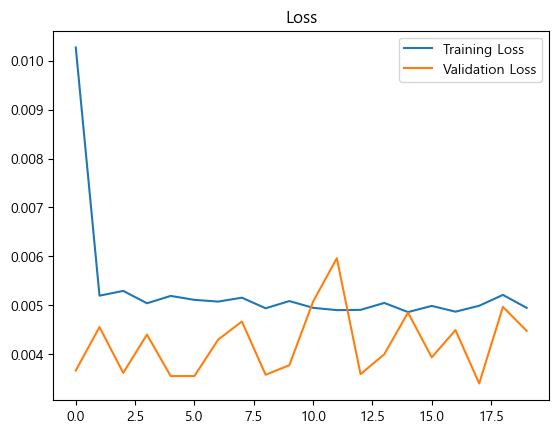

In [233]:
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

---
## 예측 평가

In [254]:
nbeat_pred = model.predict(test_X)
lstm_pred = modelnon0.predict(test_X)

1/1 [==============================] - 0s 16ms/step


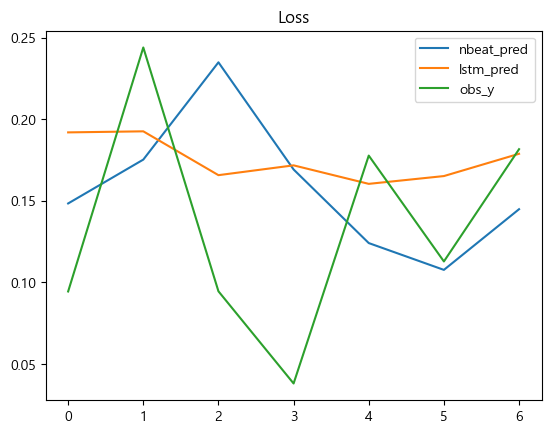

In [255]:
i=4


plt.plot(nbeat_pred[i] ,label='nbeat_pred')
plt.plot(lstm_pred[i] ,label='lstm_pred')
plt.plot(test_y[i] ,label='obs_y')
plt.title('Loss')
plt.legend()
plt.show()

In [256]:
from sklearn.metrics import mean_squared_error


print(np.mean([mean_squared_error(test_y[i],nbeat_pred[i]) for i in range(len(test_y))]))
print(np.mean([mean_squared_error(test_y[i],lstm_pred[i]) for i in range(len(test_y))]))

0.0038819646904733386
0.004472182960946883


---
## 반복 fittng


In [307]:
nbeat_lst=[]
nbeat_time = []
for i in range(50):
    K.clear_session()
    model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,1,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=optimizer )
    
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history = model.fit(train_X,train_y, validation_data = [test_X,test_y],
                    epochs=5, batch_size=16, verbose=0,
                    callbacks=[early_stop])
    nbeat_time2 = time.time()
    total_training_time0 =nbeat_time2- nbeat_time1
    nbeat_pred = model.predict(test_X)
    nbeat_mse=np.mean([mean_squared_error(test_y[i],nbeat_pred[i]) for i in range(len(test_y))])
    nbeat_lst.append(nbeat_mse)
    nbeat_time.append(total_training_time0)

1/1 [==============================] - 1s 764ms/step


In [284]:
lstm_lst=[]
lstm_time = []
for i in range(50):
    K.clear_session()
    modelnon0 = Sequential() # Sequeatial Model
    modelnon0.add(LSTM(128, return_sequences=False,input_shape=(21, 1)))# (timestep, feature)
    modelnon0.add(Dense(7)) # output = 1
    modelnon0.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1
                          )

    lstm_time1 = time.time()
    lstm_history= modelnon0.fit(train_X,train_y, validation_data = [test_X,test_y], epochs=20,
          batch_size=16, verbose=0, callbacks=[early_stop])
    lstm_time2 = time.time()
    lstm_pred = modelnon0.predict(test_X)
    lstm_mse=np.mean([mean_squared_error(test_y[i],lstm_pred[i]) for i in range(len(test_y))])
    total_training_time1 =lstm_time2- lstm_time1
    
    lstm_time.append(total_training_time1)
    lstm_lst.append(lstm_mse)

Epoch 18: early stopping
1/1 [==============================] - 0s 271ms/step
Epoch 19: early stopping
1/1 [==============================] - 0s 270ms/step
Epoch 11: early stopping
1/1 [==============================] - 0s 270ms/step
Epoch 16: early stopping
1/1 [==============================] - 0s 271ms/step
Epoch 18: early stopping
1/1 [==============================] - 0s 270ms/step
Epoch 20: early stopping
1/1 [==============================] - 0s 273ms/step
Epoch 10: early stopping
1/1 [==============================] - 0s 274ms/step
Epoch 19: early stopping
1/1 [==============================] - 0s 279ms/step
Epoch 16: early stopping
1/1 [==============================] - 0s 273ms/step
Epoch 8: early stopping
1/1 [==============================] - 0s 274ms/step
Epoch 11: early stopping
1/1 [==============================] - 0s 277ms/step
Epoch 15: early stopping
1/1 [==============================] - 0s 273ms/step
Epoch 16: early stopping
1/1 [==============================] - 0

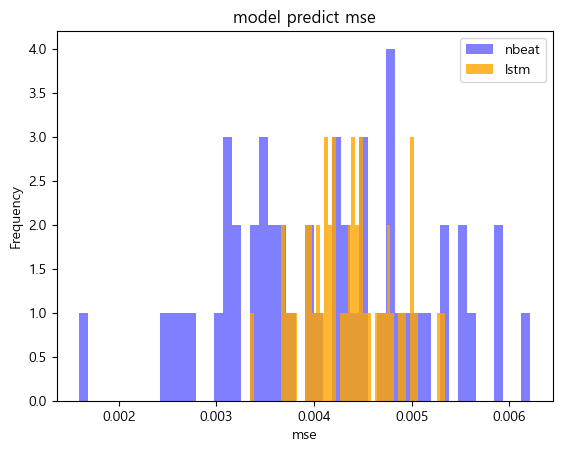

In [308]:

bins = 50

plt.hist(nbeat_lst, bins=bins, alpha=0.5, label='nbeat', color='blue')
plt.hist(lstm_lst, bins=bins, alpha=0.8, label='lstm', color='orange')

plt.xlabel('mse')
plt.ylabel('Frequency')
plt.title('model predict mse')
plt.legend()
plt.show()


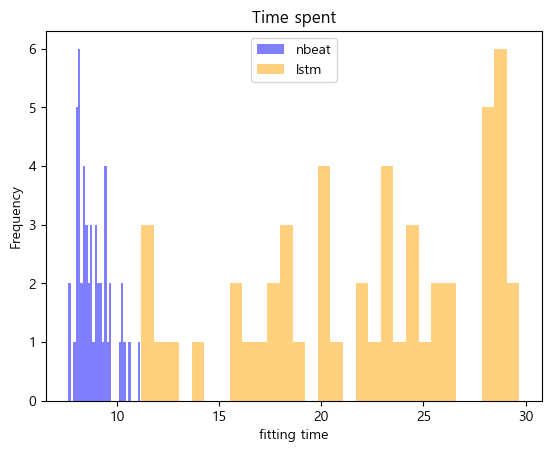

In [309]:

bins = 30

plt.hist(nbeat_time, bins=bins, alpha=0.5, label='nbeat', color='blue')
plt.hist(lstm_time, bins=bins, alpha=0.5, label='lstm', color='orange')

plt.xlabel('fitting time')
plt.ylabel('Frequency')
plt.title('Time spent')
plt.legend()
plt.show()
